In [151]:
import theano; 
theano.config.blas.ldflags=""  #-LC:\openblas\bin -lopenblas"
print (theano.config.blas.ldflags)
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Reshape,Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
#import tensorflow as tf
from keras.optimizers import Adam
from scipy.misc import imresize
#from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline
from skimage.filters import roberts, sobel, scharr, prewitt


#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

Let's prepare our data so that we can read it into our model. Since the data is super big we need a generator to read it a few at a time into memory.

In [112]:
# set the necessary directories
data_dir = 'C:/data/kag/d/train/train/'#"../input/train/"
mask_dir = 'C:/data/kag/d/train_masks/train_masks/' #"../input/train_masks/"
all_images = os.listdir(data_dir)

In [113]:
# pick which images we will use for testing and which for validation
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

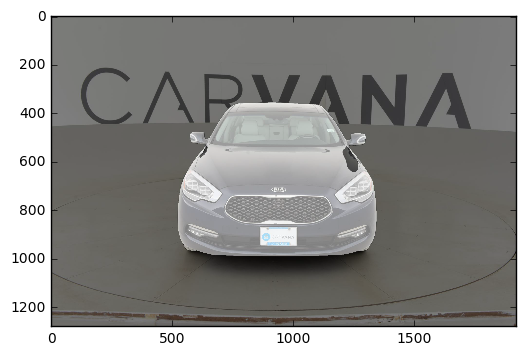

In [344]:
plt.imshow(load_img(data_dir+'8d1a6723c458_01.jpg'))
msk=load_img(mask_dir+'8d1a6723c458_01_mask.gif')
type(msk)
plt.imshow(msk, alpha=0.5)
#plt.imshow(grey2rgb(msk[0].reshape(128,128,1)), alpha=0.5) 

In [ ]:
class BatchIndices(object):
    # if n=10 bs=3 you will get [0,1,2] [3,4,5,] , [6,7,8] [9] (! not right BS) and then back again
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res
        
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        # In=1024 , o=800.  if test, always get last (1024-800:1024). if train, get random slice in this size.
        # not useful for out<<in.
        start = random.randint(0, i-o) if self.train else (i-o) 
        return slice(start, start+o) #the actual python slicer(!) to be used later... like start:start+0

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): #reflection
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)
    

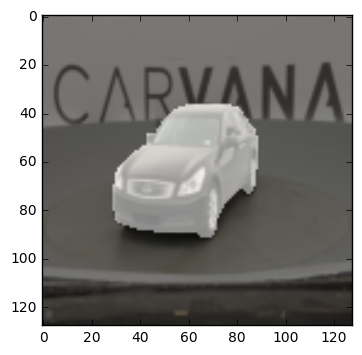

In [245]:
# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            sample_weights = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                # note that if dims!= original, interpolution will happen  (0.5, 0.9 instead of binary values)
                array_mask = img_to_array(resized_mask)/255
                array_mask = (array_mask > 0.5).astype(np.float32)
                labels.append(array_mask[:, :, 0])
                
                
                #now to a trick.let's change them to edges!
                edges = sobel(array_mask[:,:,0])
                edges= np.array(edges > 0.1,dtype=np.float32)
                edges[:,:]*=0.99 # 1 and 0 -> 0.99 and 0
                edges[:,:]+=0.01
                #DELETE THIS
                sample_weights.append(edges[:, :])  #importance
                
                
                
                
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            #INSTEAD OF labels= labels.reshape(-1, dims[0], dims[1], 1)
            labels= labels.reshape(-1, dims[0]*dims[1], 1)
            #print ('lables',labels.shape)
            sample_weights = np.array(sample_weights)
            sample_weights = sample_weights.reshape(-1, dims[0]*dims[1])
            #print (sample_weights.shape)
            #sample_weights = np.squeeze(np.sum(sample_weights, axis=-1))
            #print (sample_weights.shape)
            yield imgs, labels,sample_weights

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 5, [128, 128])
val_gen =   data_gen_small(data_dir, mask_dir, validation_images, 5, [128, 128])
img, msk, sample_w = next(train_gen)

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0].reshape(128,128,1)), alpha=0.5) #ugly trcik to add sample_weights

Now let's get started with making our actual network.

In [269]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [270]:
# Make a custom U-nets implementation.
filters = 8 #<--64
input_layer = Input(shape = [128, 128, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

#INSTEAD OF: out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)
out = Conv2D(filters=1, kernel_size=(1, 1))(up4)
out = Reshape((128*128,1))(out)
out = Activation('sigmoid')(out)


model = Model(input_layer, out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_185 (Conv2D)              (None, 128, 128, 8)   224         input_9[0][0]                    
____________________________________________________________________________________________________
conv2d_186 (Conv2D)              (None, 128, 128, 8)   584         conv2d_185[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D)  (None, 64, 64, 8)     0           conv2d_186[0][0]                 
___________________________________________________________________________________________

In [271]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
import keras.backend as tf
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    #isct = tf.reduce_sum(y_true * y_pred)
    isct = tf.sum(y_true * y_pred)
    
    return 2 * isct / (tf.sum(y_true) + tf.sum(y_pred))

In [347]:
# Training time!
# probably need to play around a little bit with the learning rate to get it to start learning
#model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
#model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=[dice_coef],
#             sample_weight_mode='temporal')
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'],
             sample_weight_mode='temporal')
#model.fit_generator(train_gen, steps_per_epoch=120, epochs=1,
#                    validation_data =val_gen,validation_steps = 20,workers=1,)

In [348]:
from keras.models import load_model
model.save('unet128_5000imgs_0.98_random_valid.h5')
model2 = load_model('unet128_5000imgs_0.98_random_valid.h5')


(5L, 128L, 128L, 3L)
('msk', (16384L, 1L))
('pred_msk', (16384L, 1L))
(16384L,)
Groud-truth


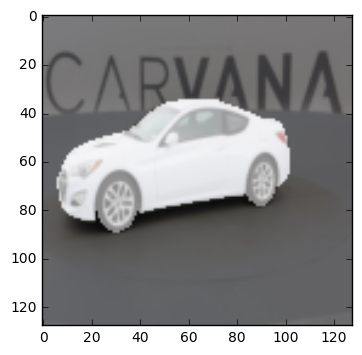

Predicted


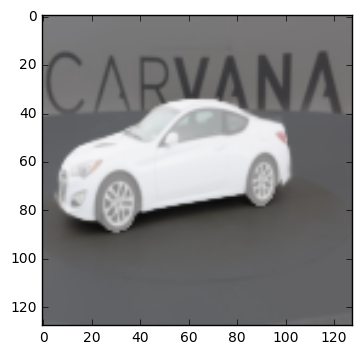

Edges
('msk', (16384L, 1L))
('pred_msk', (16384L, 1L))
(16384L,)
Groud-truth


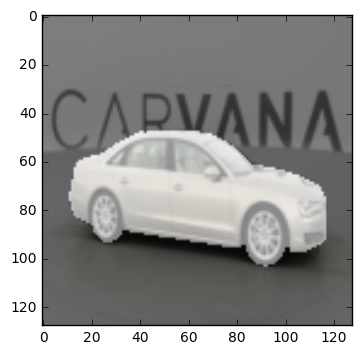

Predicted


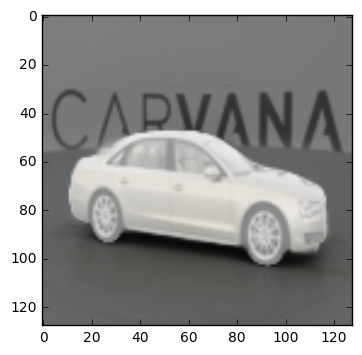

Edges
('msk', (16384L, 1L))
('pred_msk', (16384L, 1L))
(16384L,)
Groud-truth


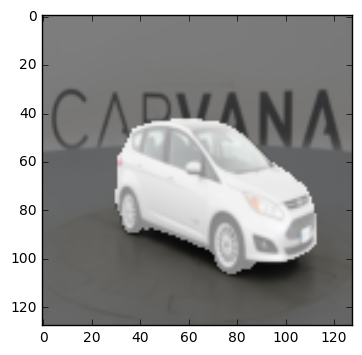

Predicted


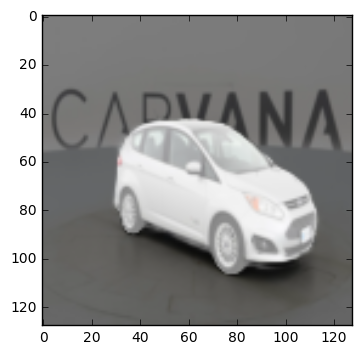

Edges
('msk', (16384L, 1L))
('pred_msk', (16384L, 1L))
(16384L,)
Groud-truth


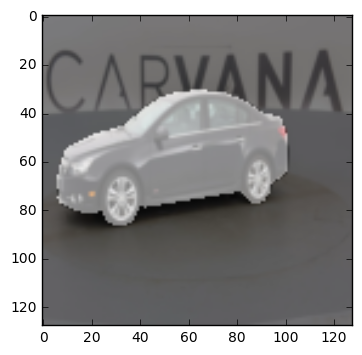

Predicted


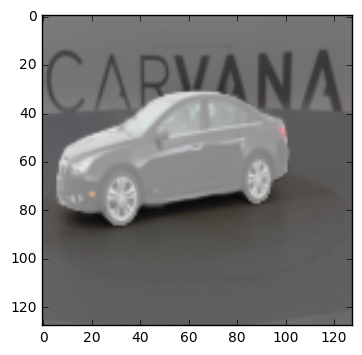

Edges
('msk', (16384L, 1L))
('pred_msk', (16384L, 1L))
(16384L,)
Groud-truth


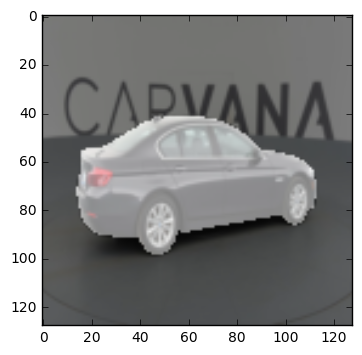

Predicted


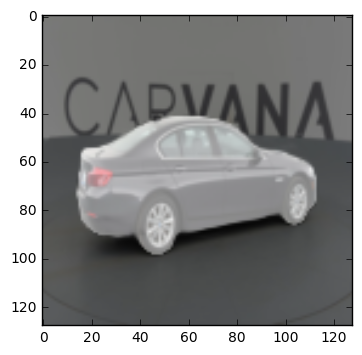

Edges


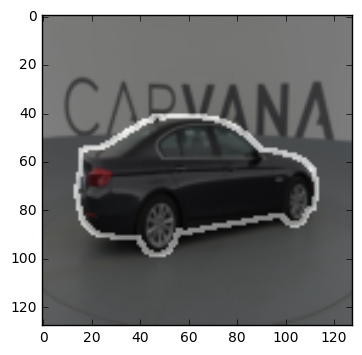

In [349]:
img, msk,s_w = next(val_gen) #next(train_gen)
#img, msk = next(train_gen)
print (img[:5].shape)
pred_msk = model2.predict(img[:5])
for i in range(5):
    print('msk',msk[i].shape)
    print('pred_msk',pred_msk[0].shape)
    #pred_msk[0][np.where(pred_msk[0]>=0.5)]=1
    #pred_msk[0][np.where(pred_msk[0]<0.5)]=0
    print (s_w[i].shape)

    print ('Groud-truth')
    plt.imshow(img[i])
    plt.imshow(grey2rgb(msk[i].reshape( (128,128,1) )), alpha=0.5)
    plt.show()

    print ('Predicted')
    plt.imshow(img[i])
    plt.imshow(grey2rgb(pred_msk[i].reshape( (128,128,1) )), alpha=0.5)
    plt.show()
    print ('Edges')
    plt.imshow(img[i])
    plt.imshow(grey2rgb(s_w[i].reshape( (128,128,1) )), alpha=0.5)


           

In [299]:
print ('len',np.where(s_w[0]==1)[0].shape)  #486>1  vs 15898 -->3% of pixels are borders (drawn with coarse line)
print (s_w[0].mean())
print (s_w[0].reshape(128,128)[20:60,40:60])
print ('\n\n')
print (pred_msk.reshape(128,128)[20:60,40:60])
15898*0.01


('len', (507L,))
0.0406354
[[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0

158.98

((128L, 128L), dtype('float32'))
((128L, 128L), dtype('float32'))
('edges', (128L, 128L), dtype('float32'))
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.  0.  0.  0.  0.  0

IndexError: too many indices for array

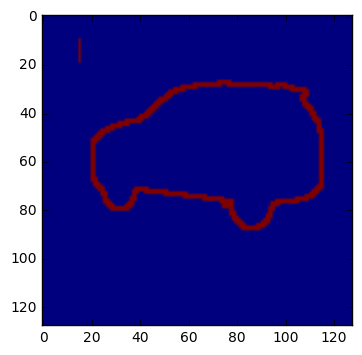

In [233]:
# 128x128 is far from good resolution. How to increase? sliding-window, or one very big?
# higher weights on the border pixels
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.data import camera

img, msk,edge= next(train_gen)
#pred_msk = model.predict(img[:1])
#plt.imshow(img[0])
#plt.imshow(grey2rgb(pred_msk[0]), alpha=0.5)
plt.show()
np.set_printoptions(precision=2,suppress =True,linewidth=200)

m = msk[0].reshape((128,128))
#m = np.array(m,dtype=np.uint8)
print (m.shape,m.dtype)
edges =sobel(m)
edges= np.array(edges > 0,dtype=np.float32)
print (m.shape,m.dtype)
print ('edges',edges.shape,edges.dtype)
r1,r2,c1,c2= 33,50,33,50
print (edges[r1:r2,c1:c2])
edges[10:20,15]=1

plt.imshow(edges)
m=  msk[0,:,:,0]
print (m.shape,m.dtype)
print ('m',m.shape,m.dtype) 
print ('m',m.shape,m.dtype) 
print (m[r1:r2,c1:c2])


#plt.imshow(img[0][r1:r2,c1:c2])
#plt.imshow(grey2rgb(msk[0][r1:r2,c1:c2]), alpha=0.5)
#plt.imshow(edges[r1:r2,c1:c2], alpha=0.5,cmap=plt.cm.gray)
#plt.tight_layout()
#plt.show()

plt.imshow(edge_roberts,cmap=plt.cm.gray)


In [332]:
hash (frozenset(sorted({ 'y':'4','x':'3' }.items()) + ['hey','there']))
3

3